<a href="https://colab.research.google.com/github/KagontleBooysen/alu-machine_learning/blob/master/Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import zipfile
import nltk
import os
import tensorflow as tf
from googletrans import Translator
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from google.colab import drive

# Mount Google Drive7

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 7.6 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17395 sha256=8f5047fdaffa32b523e08eb0aeae18c1f28541baedb5c17b389a38f1aea255b2
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling c

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [5]:
import tensorflow as tf

# Check if TensorFlow can see the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Optional: List all physical devices
print(tf.config.experimental.list_physical_devices())


Num GPUs Available:  0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
import tensorflow as tf

# Create a simple operation
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [7]:
# Extract the zip file
def extract_zip(zip_file_path, extract_to='.'):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Assume the zip file is named 'dataset.zip' and contains 'eng_setswana.txt'
extract_zip('/content/drive/MyDrive/english_setswana.zip',extract_to='/content/drive/MyDrive/')

In [8]:
# Set the file paths for English and Setswana sentences
eng_file_path = '/content/drive/MyDrive/english_setswana/english.txt'
sets_file_path = '/content/drive/MyDrive/english_setswana/setswana.txt'

In [9]:
# Function to load and process data
def load_and_process_data(eng_file_path, sets_file_path):
    with open(eng_file_path, 'r', encoding='utf-8') as file:
        english_sentences = file.read().splitlines()

    with open(sets_file_path, 'r', encoding='utf-8') as file:
        setswana_sentences = file.read().splitlines()

    setswana_sentences = [f'startseq {sent} endseq' for sent in setswana_sentences]

    return english_sentences, setswana_sentences

In [10]:
# Function to print the first few lines of a file
def print_file_preview(file_path, num_lines=5):
    with open(file_path, 'r', encoding='ISO-8859-1') as file:
        for _ in range(num_lines):
            print(file.readline().strip())

In [11]:
# Check the contents of the English file
print("Preview of the English file:")
print_file_preview('/content/drive/MyDrive/english_setswana/english.txt')

# Check the contents of the Setswana file
print("Preview of the Setswana file:")
print_file_preview('/content/drive/MyDrive/english_setswana/setswana.txt')

Preview of the English file:
Good progress has been made with the staff composition project in each of the 15 faculties at the NWU .
The rector , Prof Thanyani Mariba , congratulated the newcomers on their choice to further their studies at the campus and emphasised the importance of choice and responsibility - both in terms of academic commitments and social endeavours .
Complaints against Correctional Services staff , court officials and members of the South African National Defence Force .
biliary duct
What's noticeable is that the Mafikeng participants in the 2005 survey were not particularly impressed with their working environments .
Preview of the Setswana file:
Lo tla lemoga gore Thulaganyo ya Setheo ya 2012-2014 e e dirwang mo mafapheng otlhe ka tsamaiso ya ditumalano tsa go dira tiro ke ya gore YBB e fitlhelele maikemisetso a yone kgato ka kgato .
Moreketoro , Mop Thanyani Mariba , o ne a akgolela batlaboÅ¡eng tlhopho e ba e dirileng ya go tla go tswelela dithuto tsa bone mo 

In [12]:
# Load data from the two files
def load_data(file_path_english, file_path_setswana):
    english_sentences = []
    setswana_sentences = []

    with open(file_path_english, 'r', encoding='ISO-8859-1') as file_eng, open(file_path_setswana, 'r', encoding='ISO-8859-1') as file_sets:
        for eng, sets in zip(file_eng, file_sets):
            english_sentences.append(eng.strip())
            setswana_sentences.append(sets.strip())

    return english_sentences, setswana_sentences

In [13]:
# Load the data from the extracted files
english_sentences, setswana_sentences = load_data(
    '/content/drive/MyDrive/english_setswana/english.txt',
    '/content/drive/MyDrive/english_setswana/setswana.txt'
)

In [14]:
# Add startseq and endseq tokens to Setswana sentences
def add_sequence_tokens(sentences):
    return [f'startseq {sentence} endseq' for sentence in sentences]

# Add tokens to Setswana sentences
setswana_sentences = add_sequence_tokens(setswana_sentences)

In [15]:
# Tokenize the sentences
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(english_sentences)
sequences_eng = tokenizer_eng.texts_to_sequences(english_sentences)
max_len_eng = max([len(seq) for seq in sequences_eng])
padded_eng = pad_sequences(sequences_eng, maxlen=max_len_eng, padding='post')

tokenizer_setswana = Tokenizer()
tokenizer_setswana.fit_on_texts(setswana_sentences)
sequences_setswana = tokenizer_setswana.texts_to_sequences(setswana_sentences)
max_len_setswana = max([len(seq) for seq in sequences_setswana])
padded_setswana = pad_sequences(sequences_setswana, maxlen=max_len_setswana, padding='post')

In [16]:
# GloVe embeddings path
glove_file_path = '/content/drive/MyDrive/glove.6B.50d.txt'

In [17]:
# Function to print contents of the file
def print_file_contents(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        for i in range(5):
            line = file.readline().strip()
            print(line)

# Print contents of the GloVe embeddings file
print("Contents of the GloVe embeddings file:")
print_file_contents(glove_file_path)

Contents of the GloVe embeddings file:
the 0.418 0.24968 -0.41242 0.1217 0.34527 -0.044457 -0.49688 -0.17862 -0.00066023 -0.6566 0.27843 -0.14767 -0.55677 0.14658 -0.0095095 0.011658 0.10204 -0.12792 -0.8443 -0.12181 -0.016801 -0.33279 -0.1552 -0.23131 -0.19181 -1.8823 -0.76746 0.099051 -0.42125 -0.19526 4.0071 -0.18594 -0.52287 -0.31681 0.00059213 0.0074449 0.17778 -0.15897 0.012041 -0.054223 -0.29871 -0.15749 -0.34758 -0.045637 -0.44251 0.18785 0.0027849 -0.18411 -0.11514 -0.78581
, 0.013441 0.23682 -0.16899 0.40951 0.63812 0.47709 -0.42852 -0.55641 -0.364 -0.23938 0.13001 -0.063734 -0.39575 -0.48162 0.23291 0.090201 -0.13324 0.078639 -0.41634 -0.15428 0.10068 0.48891 0.31226 -0.1252 -0.037512 -1.5179 0.12612 -0.02442 -0.042961 -0.28351 3.5416 -0.11956 -0.014533 -0.1499 0.21864 -0.33412 -0.13872 0.31806 0.70358 0.44858 -0.080262 0.63003 0.32111 -0.46765 0.22786 0.36034 -0.37818 -0.56657 0.044691 0.30392
. 0.15164 0.30177 -0.16763 0.17684 0.31719 0.33973 -0.43478 -0.31086 -0.44999 -0.

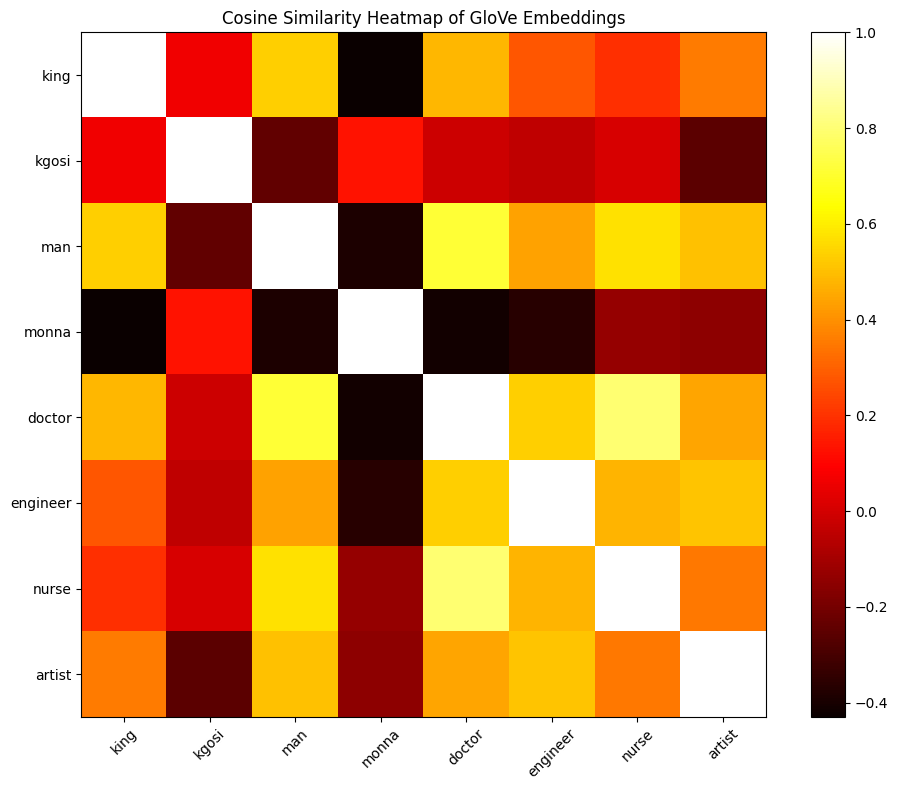

In [18]:
# Load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load GloVe embeddings
glove_embeddings_index = load_glove_embeddings(glove_file_path)

# Select a subset of words for visualization
words_of_interest = ['king', 'kgosi', 'man', 'monna', 'doctor', 'engineer', 'nurse', 'artist']

# Check if all words of interest are in the GloVe embeddings
for word in words_of_interest:
    if word not in glove_embeddings_index:
        print(f"Warning: The word '{word}' is not found in the GloVe embeddings.")


# Create a similarity matrix for selected words
similarity_matrix = np.zeros((len(words_of_interest), len(words_of_interest)))
for i, word1 in enumerate(words_of_interest):
    for j, word2 in enumerate(words_of_interest):
        vec1 = glove_embeddings_index[word1].reshape(1, -1)
        vec2 = glove_embeddings_index[word2].reshape(1, -1)
        similarity_matrix[i, j] = cosine_similarity(vec1, vec2)[0, 0]

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(words_of_interest)), words_of_interest, rotation=45)
plt.yticks(np.arange(len(words_of_interest)), words_of_interest)
plt.title('Cosine Similarity Heatmap of GloVe Embeddings')
plt.tight_layout()
plt.show()

In [19]:
# Prepare embedding matrix
embedding_dim = 50
word_index_eng = tokenizer_eng.word_index
num_words_eng = len(word_index_eng) + 1
embedding_matrix_eng = np.zeros((num_words_eng, embedding_dim))

for word, i in word_index_eng.items():
    embedding_vector = glove_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_eng[i] = embedding_vector

In [20]:
# Define model parameters
embedding_dim = 50
units = 1024
vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_setswana = len(tokenizer_setswana.word_index) + 1

In [21]:
# Define your neural network model with GloVe embeddings
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

model = Sequential()
model.add(Embedding(num_words_eng, embedding_dim, weights=[embedding_matrix_eng], input_length=max_len_eng, trainable=False))
model.add(Bidirectional(LSTM(units)))
model.add(Dense(vocab_size_setswana, activation='softmax'))

In [22]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

In [23]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 126, 50)           1237550   
                                                                 
 bidirectional (Bidirection  (None, 2048)              8806400   
 al)                                                             
                                                                 
 dense (Dense)               (None, 31697)             64947153  
                                                                 
Total params: 74991103 (286.07 MB)
Trainable params: 73753553 (281.35 MB)
Non-trainable params: 1237550 (4.72 MB)
_________________________________________________________________


In [24]:
# calculate BLEU score for a pair of sentences
def calculate_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    reference = [reference.split()]  # BLEU expects a list of references
    hypothesis = hypothesis.split()
    score = sentence_bleu(reference, hypothesis, smoothing_function=smoothie)
    return score

In [25]:
# Initialize Google Translator
translator = Translator()

In [26]:
# Function to translate English sentence to Setswana using Google Translate
def translate_to_setswana(sentence):
    translation = translator.translate(sentence, src='en', dest='st')
    return translation.text

In [27]:
def translate_sentence(sentence):
    # This is a placeholder for an actual translation model
    # For now, it just returns the same English sentence as the "translation"
    return sentence

In [28]:
# Calculate BLEU scores for the first few translations
for i in range(5):
    reference = setswana_sentences[i]
    english_sentence = english_sentences[i]
    hypothesis = translate_to_setswana(english_sentence)
    bleu_score = calculate_bleu(reference, hypothesis)
    print(f"BLEU score for sentence {i+1}: {bleu_score:.4f}")

BLEU score for sentence 1: 0.0095
BLEU score for sentence 2: 0.0053
BLEU score for sentence 3: 0.0160
BLEU score for sentence 4: 0.0000
BLEU score for sentence 5: 0.0252


In [29]:
# Build the model
encoder_inputs = Input(shape=(max_len_eng,))
enc_emb = Embedding(vocab_size_eng, embedding_dim, mask_zero=True)(encoder_inputs)
encoder_lstm = Bidirectional(LSTM(units, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(enc_emb)
state_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
state_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_len_setswana,))
dec_emb_layer = Embedding(vocab_size_setswana, embedding_dim, mask_zero=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units * 2, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_setswana, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
# Prepare the target data for training
target_data = np.expand_dims(padded_setswana, axis=-1)

In [ ]:
# Train the model
model.fit([padded_eng, padded_setswana], target_data, batch_size=64, epochs=5, validation_split=0.2)

Epoch 1/5
915/915 [==============================] - 1198s 1s/step - loss: 4.2045 - accuracy: 0.4304 - val_loss: 2.6200 - val_accuracy: 0.6695
Epoch 2/5
915/915 [==============================] - 1135s 1s/step - loss: 2.0753 - accuracy: 0.7364 - val_loss: 1.6960 - val_accuracy: 0.7908
Epoch 3/5
915/915 [==============================] - 1172s 1s/step - loss: 1.4420 - accuracy: 0.8185 - val_loss: 1.3143 - val_accuracy: 0.8402
Epoch 4/5
915/915 [==============================] - 1174s 1s/step - loss: 1.1255 - accuracy: 0.8573 - val_loss: 1.1079 - val_accuracy: 0.8662
Epoch 5/5
220/915 [======>.......................] - ETA: 13:03 - loss: 0.9619 - accuracy: 0.8754

In [31]:
# Function to translate sentences
def translate_sentence(sentence):
    sequence = tokenizer_eng.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_len_eng, padding='post')
    states_value = encoder_model.predict(padded_sequence)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_setswana.word_index['startseq']

    stop_condition = False
    translated_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer_setswana.index_word.get(sampled_token_index, '')

        if sampled_word == 'endseq' or len(translated_sentence.split()) >= max_len_setswana:
            stop_condition = True
        else:
            if sampled_word != 'startseq':  # Skip 'startseq' token
                translated_sentence += ' ' + sampled_word

        # Debug print to trace the translation process
        print(f'Current translation: {translated_sentence.strip()}')

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        states_value = [h, c]

    return translated_sentence.strip()

In [32]:
# Define encoder and decoder models for inference
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(units*2,))
decoder_state_input_c = Input(shape=(units*2,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2
)

In [33]:
# Example translation
example_sentence = "The history of the world's most important social media platform, the author of the book, the book of Proverbs, the author of the book of Proverbs, the Book of Life The author of the e-mail address of the student's first class of students completed the alternaria social media freeked by the name of the author of the book 800 copies of the 182"
translated_sentence = translate_sentence(example_sentence)
print(f'Translated sentence: {translated_sentence}')

1/1 [==============================] - 1s 1s/step
Current translation: tlwaeditswe
1/1 [==============================] - 0s 58ms/step
Current translation: tlwaeditswe tlwaeditswe
1/1 [==============================] - 0s 79ms/step
Current translation: tlwaeditswe tlwaeditswe december
1/1 [==============================] - 0s 84ms/step
Current translation: tlwaeditswe tlwaeditswe december phitlhelelokgolothutong
1/1 [==============================] - 0s 77ms/step
Current translation: tlwaeditswe tlwaeditswe december phitlhelelokgolothutong tsokotsa
1/1 [==============================] - 0s 86ms/step
Current translation: tlwaeditswe tlwaeditswe december phitlhelelokgolothutong tsokotsa selekanomotlakase
1/1 [==============================] - 0s 77ms/step
Current translation: tlwaeditswe tlwaeditswe december phitlhelelokgolothutong tsokotsa selekanomotlakase dialama
1/1 [==============================] - 0s 75ms/step
Current translation: tlwaeditswe tlwaeditswe december phitlhelelokgolot